In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [2]:
directory = 't'

# Get all images from dir
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=directory, color_mode='rgb',
                                                   batch_size=128, image_size=(32,32), label_mode=None,
                                                   shuffle=True, seed=42)

# Normalize the data

dataset=dataset.map(lambda x: x /255.00)

Found 30000 files.


In [3]:
# Grid of image
from mpl_toolkits.axes_grid1 import ImageGrid

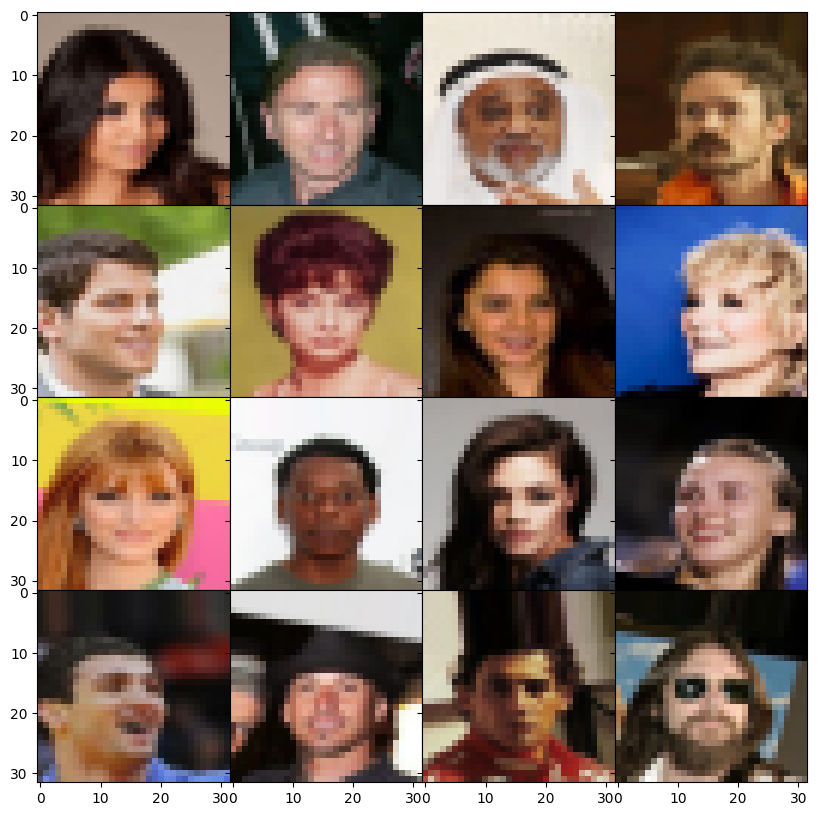

In [4]:
it=iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16,:,:,:]

# show the image

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), 
         axes_pad=0)
for ax,im in zip(grid, images):
    ax.imshow(im)
plt.show()

GANs-> Generartive Adversarial Network
Generator, Disc.
Disc.-> Image Classification Task
Latent-> Noise

In [5]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape
from tensorflow.keras import Model, Input

def discriminator_model():
    disc_input = Input(shape=(32,32,3), name='discriminator_network')
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(disc_input)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same')(x)
    x=LeakyReLU()(x)
    x=Dropout(0.2)(x)
    
    x=Flatten()(x)
    x=Dense(1)(x)
    
    output = Activation('sigmoid')(x)
    
    disc=Model(inputs = disc_input, outputs=output)
    
    return disc

In [6]:
disc_model = discriminator_model()
disc_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_network           │ (None, 32, 32, 3)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,281 (1.13 MB)

 Trainable params: 297,281 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.layers import Conv2D, LeakyReLU,BatchNormalization, Dropout, Flatten, Dense, Activation, Reshape, Conv2DTranspose
from tensorflow.keras import Model, Input
def generator_model(z_dim=100):
    gen_input = Input(shape=(z_dim,), name='generator_network')
    
    x = Dense(8*8*3)(gen_input)
    x = Reshape(target_shape=(8,8,3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=512, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
        
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1), padding='same')(x)
    fake_images_gen = LeakyReLU()(x)
    
    model_gen=Model(inputs = gen_input, outputs=fake_images_gen)

    return model_gen

In [8]:
gen_model = generator_model()


In [9]:
gen_model.summary(0)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_network (InputLayer)  │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        19,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 3)        │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │        14,336 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,736,143 (6.62 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 2,182 (8.52 KB)

In [10]:
disc_model = discriminator_model()
gen_model = generator_model()
# Image Classification CNN
# Compile the model that trains disc.
disc_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
# Compile the model that trains generator
z_dim = 100
disc_model.trainable = False
model_input = Input(shape=(z_dim,), name='model_input')

model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ model_input (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 32, 32, 3)      │     1,736,143 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 1)              │       297,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033,424 (7.76 MB)

 Trainable params: 1,733,961 (6.61 MB)

 Non-trainable params: 299,463 (1.14 MB)

In [13]:
def train_discriminator(batch, batch_size):
    valid = np.ones((batch_size, 1)) 
    fake = np.zeros((batch_size, 1)) 
    
    disc_model.train_on_batch(batch, valid)
    
    noise = np.random.normal(0,1, (batch_size, z_dim))
    gen_image = gen_model.predict(noise)
    disc_model.train_on_batch(gen_image, fake)
def train_generator(batch_size):
    valid = np.ones((batch_size, 1)) 
    noise = np.random.normal(0,1, (batch_size, z_dim))
    model.train_on_batch(noise, valid)

In [14]:
def save_image(fake_image, path):
    image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
    tf.keras.preprocessing.image.save_img(path, image)
    return image
def generate_and_save_image(path):
    noise = np.random.normal(0,1, (1, z_dim))
    fake_images = gen_model(noise)
    image = save_image(fake_images[0], path)
    plt.imshow(image)
    plt.show()

In [ ]:
for epochs in range(100):
    print(f'No of Epochs-> {epochs}')
    for i,batch in enumerate(dataset):
        train_discriminator(batch, batch.shape[0])
        train_generator(batch.shape[0])

   
    if (epochs + 1) % 10 == 0:
        gen_model.save(f"generator_epoch_{epochs+1}.h5")
        disc_model.save(f"discriminator_epoch_{epochs+1}.h5")
        print(f"Saved models at epoch {epochs+1}")

No of Epochs-> 0
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81m

Saved models at epoch 10
No of Epochs-> 10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━

In [16]:
if i%100==0:
            print(f'Batch Images-> {i}')
            PATH = 'generate_face'
            generate_and_save_image(path = f'{PATH}/epochs_{epochs}batch_{i}.jpg')


 Loading generator from: generator_epoch_100.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


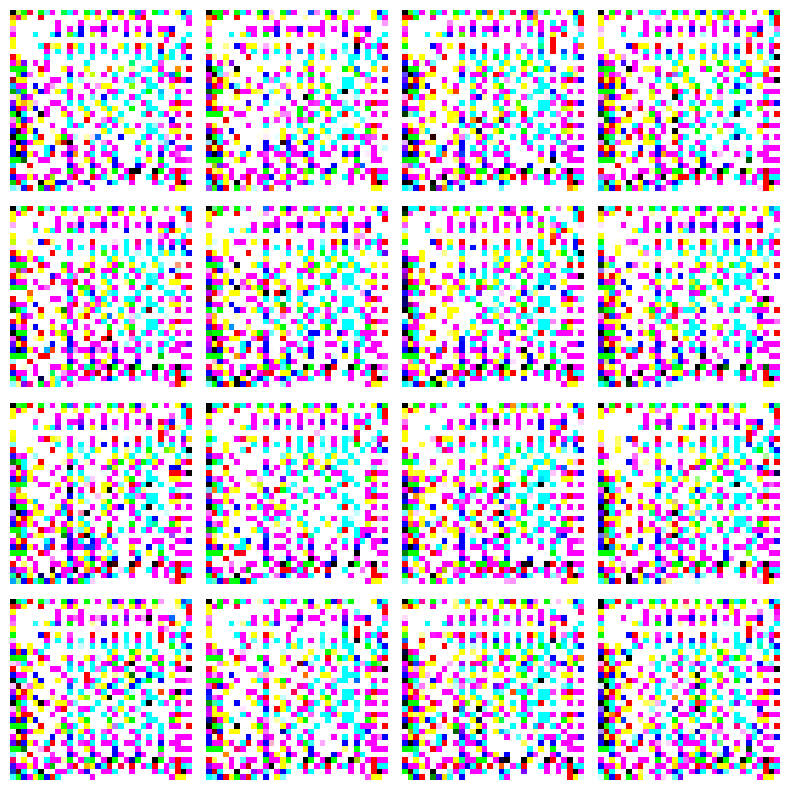

In [17]:
# ==== TESTING FUNCTION ====

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
z_dim = 100

def test_generator(model_path='generator_epoch_100.h5', n_images=16):
    print(f"\n Loading generator from: {model_path}")
    gen_model = tf.keras.models.load_model(model_path)
    noise = np.random.normal(0, 1, (n_images, z_dim))
    gen_imgs = gen_model.predict(noise)

    cols = int(np.sqrt(n_images))
    rows = int(np.ceil(n_images / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axs = axs.flatten()

    for i in range(n_images):
        axs[i].imshow(gen_imgs[i])
        axs[i].axis('off')

    for j in range(n_images, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

test_generator('generator_epoch_100.h5', n_images=16)